In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid 
from torchvision.models import resnet50, ResNet50_Weights
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import utils
from models import Classificator

## Hyperparameters

In [20]:
#Dataloader params
BATCH_SIZE = 32
NUM_WORKERS = 7 # 7 because that what it suggested in a warning message
PERSISTENT_WORKERS = True # Suggested to do this in a warning message for faster init
USE_AUGMENT = True
CUSTOM_TRAIN_VAL_SPLIT = True
DATA_DIR = "chest_xray" # Change this to chest_xray folder
USE_SAMPLER = False
SHOW_ANALYTICS = False

# Lightning moduls params
LEARNING_RATE = 1e-3
CLASS_NUM = 2
EPOCHS = 1
CLASS_LABELS = ["Normal", "Pneumonia"]
NUM_CLASSES = 2

config = {
    "lr": LEARNING_RATE,
    "loss": "CrossEntropyLoss"
}



## Load data

In [21]:
train_loader, val_loader, test_loader = utils.loadData(
    batchSize=BATCH_SIZE,
    numWorkers=NUM_WORKERS,
    dataDir=DATA_DIR,
    customSplit=CUSTOM_TRAIN_VAL_SPLIT,
    useAugment=USE_AUGMENT,
    useSampler=USE_SAMPLER,
    showAnalytics=SHOW_ANALYTICS
)

## Plot some example images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1, 0, 1],
        [1, 1, 1],
        [1, 1, 1]])


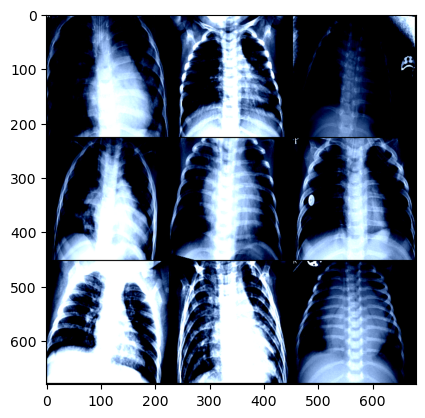

In [22]:
examples = next(iter(train_loader))
images, labels = examples
grid = make_grid(images[:9], nrow=3)
plt.imshow(grid.permute(1, 2, 0))
print(labels[:9].reshape(3,3))

## Load ResNet50 model

In [23]:
#Load best resNet50 weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

#Change output layer to 2 classes
model.fc = torch.nn.Linear(
    in_features=2048,
    out_features=NUM_CLASSES,
    bias=True
)

#model.fc = nn.Sequential()

#Freeze all layers except fc
for name, param in model.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


## Run training and validation loops

In [24]:
classifier = Classificator(model, CLASS_LABELS, config, NUM_CLASSES)
early_stop_callback = EarlyStopping(monitor="Validation loss", min_delta=1e-6, patience=10)
checkpoint = L.pytorch.callbacks.ModelCheckpoint(dirpath="pneumonia_model/ResNet/")
callbacks = [early_stop_callback, checkpoint]
logger = TensorBoardLogger("lightning_logs",
                           name=f"resnet/{'augment' if USE_AUGMENT else 'original'}",
                           )

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    logger=logger,
    max_epochs=EPOCHS,
    reload_dataloaders_every_n_epochs=3,
    callbacks=callbacks
)
trainer.fit(
    model = classifier,
    train_dataloaders = train_loader, 
    val_dataloaders = val_loader
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/emillundin/Desktop/D7047E/D7047E-Project/D7047E-Project/pneumonia_model/ResNet exists and is not empty.

  | Name                  | Type                  | Params
----------------------------------------------------------------
0 | CNN                   | ResNet                | 23.5 M
1 | loss                  | CrossEntropyLoss      | 0     
2 | val_confusion_matrix  | BinaryConfusionMatrix | 0     
3 | test_confusion_matrix | BinaryConfusionMatrix | 0     
4 | train_metrics         | MetricCollection      | 0     
5 | valid_metrics         | MetricCollection      | 0     
6 | test_metrics          | MetricCollection      | 0     
----------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## Test model
Only implemented and tested but should not use until final model is decided

In [25]:
#trainer.test(model = classifier, dataloaders=test_loader)

In [26]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 46915), started 0:10:13 ago. (Use '!kill 46915' to kill it.)